# Check GPU

In [1]:
import torch

gpu_available = torch.cuda.is_available()
print(f"GPU Available: {gpu_available}")

if gpu_available:
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {gpu_name}")

GPU Available: True
GPU Name: NVIDIA H100


# Load datasets

## SWiPE - full dataset

In [1]:
from datasets import Dataset, DatasetDict
import pandas as pd

train_df = pd.read_json('../data/swipe/swipe_train.json')
val_df = pd.read_json('../data/swipe/swipe_val.json')
test_id_df = pd.read_json('../data/swipe/swipe_test_id.json')
test_ood_df = pd.read_json('../data/swipe/swipe_test_ood.json')

train_dataset = Dataset.from_pandas(train_df[['r_content', 's_content','annotations','edits']])
val_dataset = Dataset.from_pandas(val_df[['r_content', 's_content','annotations','edits']])
test_id_dataset = Dataset.from_pandas(test_id_df[['r_content', 's_content','annotations','edits']])
test_ood_dataset = Dataset.from_pandas(test_ood_df[['r_content', 's_content','annotations','edits']])

swipe_full_dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test_id': test_id_dataset,
    'test_ood': test_ood_dataset
})

## SWiPE - cleaned dataset

In [3]:
from datasets import load_from_disk

swipe_clean_dataset = load_from_disk("../data/swipe_clean")

In [4]:
swipe_clean_dataset

DatasetDict({
    train: Dataset({
        features: ['r_content', 's_content'],
        num_rows: 3847
    })
    validation: Dataset({
        features: ['r_content', 's_content'],
        num_rows: 479
    })
    test_id: Dataset({
        features: ['r_content', 's_content'],
        num_rows: 483
    })
    test_ood: Dataset({
        features: ['r_content', 's_content'],
        num_rows: 368
    })
})

### Shuffle dataset

In [4]:
from datasets import DatasetDict

def shuffle_dataset_splits(dataset_dict):
    shuffled_datasets = DatasetDict()
    
    for split, dataset in dataset_dict.items():
        shuffled_datasets[split] = dataset.shuffle(seed=42)  

    return shuffled_datasets

shuffled_swipe_clean_dataset = shuffle_dataset_splits(swipe_clean_dataset)

In [5]:
shuffled_swipe_clean_dataset

DatasetDict({
    train: Dataset({
        features: ['r_content', 's_content'],
        num_rows: 3847
    })
    validation: Dataset({
        features: ['r_content', 's_content'],
        num_rows: 479
    })
    test_id: Dataset({
        features: ['r_content', 's_content'],
        num_rows: 483
    })
    test_ood: Dataset({
        features: ['r_content', 's_content'],
        num_rows: 368
    })
})

# Load the model

In [4]:
from transformers import BartTokenizerFast, BartForConditionalGeneration # BartTokenizer AutoTokenizer, AutoModelForSeq2SeqLM
import torch

tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-large') #use_fast=True) # BartTokenizerFast.from_pretrained('facebook/bart-large')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large', device_map ={'':torch.cuda.current_device()})

## Adjust model's config

In [14]:
print(model.config.dropout)

0.2


In [6]:
model.config.dropout = 0.2
print(model.config.dropout)

0.2


## Adjust the tokenizer

In [7]:
from transformers import AddedToken

special_tokens_dict = {
    'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True)
}

# add the special tokens to the tokenizer
tokenizer.add_special_tokens(special_tokens_dict)

5

In [7]:
print(tokenizer.special_tokens_map)

{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}


In [8]:
print("Clean up tokenization spaces:", tokenizer.clean_up_tokenization_spaces)

Clean up tokenization spaces: True


In [8]:
print(tokenizer)

BartTokenizerFast(name_or_path='facebook/bart-large', vocab_size=50265, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}


# Tokenize the dataset

In [9]:
def tokenize_func(examples):
    # inputs
    inputs = tokenizer(examples['r_content'], truncation=True, padding="max_length", max_length=512)
    # labels
    labels = tokenizer(examples['s_content'],truncation=True, padding="max_length", max_length=512)
    # set the labels in the input dictionary
    inputs['labels'] = labels['input_ids']
    return inputs

## Swipe-full

In [4]:
tokenized_swipe_full_dataset = swipe_full_dataset.map(tokenize_func, batched=True)
tokenized_swipe_full_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/3861 [00:00<?, ? examples/s]

Map:   0%|          | 0/482 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Map:   0%|          | 0/377 [00:00<?, ? examples/s]

## Swipe-clean

In [10]:
tokenized_swipe_clean_dataset = swipe_clean_dataset.map(tokenize_func, batched=True)
tokenized_swipe_clean_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Fine-tune

In [11]:
dataset = swipe_clean_dataset 
tokenized_dataset = tokenized_swipe_clean_dataset 

In [14]:
max_input_length = max([len(i) for i in tokenized_dataset['train']['input_ids']])
max_label_length = max([len(l) for l in tokenized_dataset['train']['labels']])

print(f"Max input length: {max_input_length}")
print(f"Max label length: {max_label_length}")

Max input length: 512
Max label length: 512


In [41]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [12]:
import os 
# disable parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Seq2SeqTrainer

In [13]:
from transformers import GenerationConfig

generation_config = GenerationConfig(
    bos_token_id = 0, 
    decoder_start_token_id = 2,
    early_stopping = True,
    eos_token_id = 2, 
    forced_bos_token_id = 0,
    forced_eos_token_id = 2,
    no_repeat_ngram_size = 3,
    num_beams = 4,
    pad_token_id = 1,
    max_length = 200,
    temperature = 1.5,
    num_return_sequences=1, 
    do_sample=True
)

model.generation_config = generation_config

In [15]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback
import numpy as np
from easse.sari import corpus_sari

def compute_sari(pred):
    
    predictions = pred.predictions
    labels = pred.label_ids
    
    # decode the predictions and labels into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # source texts 
    sources = tokenized_dataset['validation']['r_content']

    # SARI scores
    sari_scores = []
    for pred, label, source in zip(decoded_preds, decoded_labels, sources):
        sari_score = corpus_sari(
            orig_sents=[source],  # original source sentence
            sys_sents=[pred],     # system's generated sentence
            refs_sents=[[label]]  # reference simplified sentence
        )
        sari_scores.append(sari_score)
    
    # average SARI score across all examples
    avg_sari = np.mean(sari_scores)
    return {"sari": avg_sari}

model.train()

training_args = Seq2SeqTrainingArguments(
    output_dir="../models/bart-swipe-ft/results/results-swipe-clean-bart-tokenizer-fast-512-seq2seqtrainer-pred-with-gen-best-loss_dropout0.2",
    eval_strategy="epoch",
    save_strategy = "epoch",
    logging_strategy="steps",
    logging_steps=150,
    learning_rate=2e-5,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6, 
    num_train_epochs=3,
    save_total_limit=3,
    weight_decay=0.01,
    warmup_steps = 2,
    #gradient_accumulation_steps=2,
    optim = "paged_adamw_8bit",
    load_best_model_at_end=True,
    fp16=True,
    logging_dir="../models/bart-swipe-ft/logs/logs-swipe-clean-bart-tokenizer-fast-512-seq2seqtrainer-pred-with-gen-best-loss_dropout0.2",
    predict_with_generate=True,
    metric_for_best_model='loss'
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_sari,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

model.config.use_cache = False

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Sari
1,0.211200,0.181588,40.261900
2,0.156200,0.175187,42.490640
3,0.133000,0.175931,42.015964


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=1926, training_loss=0.6303604498335382, metrics={'train_runtime': 668.5668, 'train_samples_per_second': 17.262, 'train_steps_per_second': 2.881, 'total_flos': 1.2505277106487296e+16, 'train_loss': 0.6303604498335382, 'epoch': 3.0})

## Trainer

In [9]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

model.train()

training_args = TrainingArguments(
    output_dir="../models/bart-swipe-ft/results/results-swipe-clean-bart-tokenizer-fast-512-best-metric-loss-6epochs",
    eval_strategy="epoch", 
    save_strategy = "epoch", 
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=2e-5, 
    per_device_train_batch_size=6, 
    per_device_eval_batch_size=6, 
    num_train_epochs=6, 
    weight_decay=0.01,
    save_total_limit=3, 
    #gradient_accumulation_steps=6, # reduce memory
    load_best_model_at_end=True, # based on valid loss
    metric_for_best_model='loss',
    warmup_steps = 2,
    optim = "paged_adamw_8bit", # optimizer for quantization
    fp16=True, # enable half-precision
    logging_dir='../models/bart-swipe-ft/logs/logs-swipe-clean-bart-tokenizer-fast-512-best-metric-loss-6epochs'
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    #data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

model.config.use_cache = False

In [10]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.184800,0.183244
2,0.268700,0.178688
3,0.128100,0.179753
4,0.146400,0.182407
5,0.093200,0.186235


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warni

TrainOutput(global_step=3210, training_loss=0.41969726685422976, metrics={'train_runtime': 361.1736, 'train_samples_per_second': 63.908, 'train_steps_per_second': 10.665, 'total_flos': 2.084212851081216e+16, 'train_loss': 0.41969726685422976, 'epoch': 5.0})

# Visualize training process

In [12]:
num_samples = len(swipe_clean_dataset['train'])
batch_size= 6
logging_steps = 150
print("Steps per epoch: ", num_samples//batch_size )
print("Logging steps: " ,num_samples//batch_size//logging_steps )

Steps per epoch:  641
Logging steps:  4


In [17]:
log_history = trainer.state.log_history
eval_logs = [log for log in log_history if "eval_loss" in log]

# the best (lowest) validation loss
best_eval_log = min(eval_logs, key=lambda x: x["eval_loss"])

print(f"Best validation loss: {best_eval_log['eval_loss']}")
print(f"Epoch of the best model: {best_eval_log['epoch']}")
print("Sari score: ", best_eval_log['eval_sari'] )

Best validation loss: 0.17518660426139832
Epoch of the best model: 2.0
Sari score:  42.490639715645266


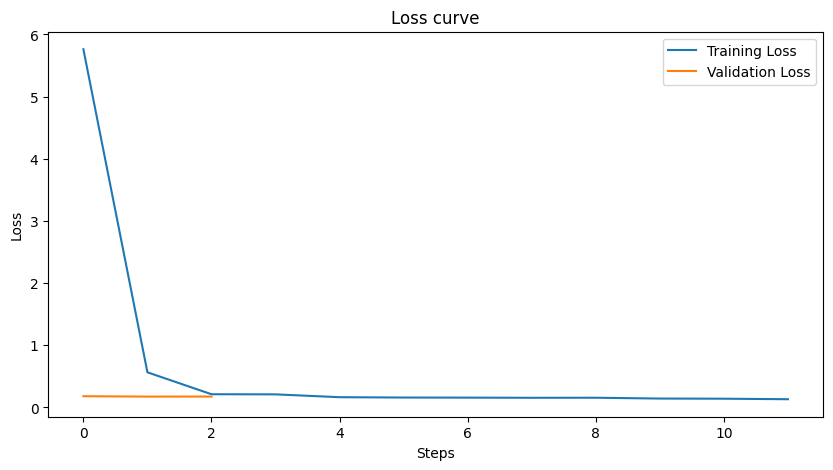

In [18]:
import matplotlib.pyplot as plt

# loss values from the log history
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
steps = range(len(train_loss))

plt.figure(figsize=(10,5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.legend()
plt.show()

# Load model from checkpoint

In [10]:
checkpoint_dir = "../models/bart-swipe-ft/results-swipe-clean-bart-tokenizer-fast-512-use-fast/checkpoint-1284"

loaded_model = BartForConditionalGeneration.from_pretrained(checkpoint_dir, device_map={'': torch.cuda.current_device()})
loaded_model.eval()

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_l

In [12]:
from transformers import GenerationConfig

loaded_model.config.use_cache = True

generation_config = GenerationConfig(
    bos_token_id = 0, 
    decoder_start_token_id = 2,
    early_stopping = True,
    eos_token_id = 2, 
    forced_bos_token_id = 0,
    forced_eos_token_id = 2,
    no_repeat_ngram_size = 3,
    num_beams = 4,
    pad_token_id = 1
)

loaded_model.generation_config = generation_config

# Generate predictions

In [11]:
import difflib
from IPython.display import display, HTML

def highlight_diff(sentence1, sentence2):
    diff = difflib.ndiff(sentence1, sentence2)
    highlighted = []
    
    for char in diff:
        if char.startswith('-'):
            highlighted.append(f"<span style='color:red'>{char[2:]}</span>")
        elif char.startswith('+'):
            highlighted.append(f"<span style='color:green'>{char[2:]}</span>")
        else:
            highlighted.append(char[2:])
    
    return ''.join(highlighted)

## example

In [12]:
from transformers import GenerationConfig

model.config.use_cache = True

generation_config = GenerationConfig(
    bos_token_id = 0, 
    decoder_start_token_id = 2,
    early_stopping = True,
    eos_token_id = 2, 
    forced_bos_token_id = 0,
    forced_eos_token_id = 2,
    no_repeat_ngram_size = 3,
    num_beams = 4,
    pad_token_id = 1
)

model.generation_config = generation_config

In [17]:
example = dataset['test_id'][1]  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = tokenizer(example['r_content'], return_tensors="pt")
inputs = {key: value.to(device) for key, value in inputs.items()}

output_ids = model.generate(
    **inputs, 
    max_length=200, 
    num_beams=5,
    temperature=1.5,
    num_return_sequences=1, 
    do_sample=True
)
simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(f"Original: {example['r_content']}", end='\n\n')
print(f"Simplified: ")
print(simplified_text, end='\n\n')
print(f"Simplified (highlighted): ")
display(HTML(highlight_diff(example['r_content'],simplified_text)))

Original: Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the former Soviet Union, and was also widely taught in schools in member countries of the Warsaw Pact. In Soviet times, Russian was often strongly promoted to the detriment of other local languages. While many of the countries of the former Soviet Union are now promoting their local languages rather than Russian, Russian remains widely spoken in these areas and is often used for intercommunication between these countries. Russian is one of the official languages of the United Nations. Russian is written using the Cyrillic alphabet. Russenorsk is a pidgin language combining Russian and Norwegian. See also: Common phrases in different languages See also: Languages of China --

Simplified: 
Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the for

# SARI score

In [19]:
from tqdm import tqdm
import torch

predictions = []

model.eval()
model.config.use_cache = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for example in tqdm(dataset['test_id']):
        # tokenize the text
        input_ids = tokenizer(example['r_content'], return_tensors="pt") # , truncation=True, padding="max_length", max_length=512)
        # move input_ids to the same device as the model
        input_ids = {key: value.to(device) for key, value in input_ids.items()}
        
        # generate prediction
        output_ids = model.generate(**input_ids, max_length=200, temperature=1.5, num_beams=4, num_return_sequences=1, do_sample=True) # ,max_length = 512, min_length=50, length_penalty=1.0) 
        simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        
        predictions.append(simplified_text)

100%|███████████████████████████████████████████| 483/483 [06:46<00:00,  1.19it/s]


In [20]:
from tqdm.notebook import tqdm
from easse.sari import corpus_sari


sari_scores_easse = []

for index, row in tqdm(enumerate(dataset["test_id"]), total=len(dataset["test_id"])):
    r_content = row['r_content'] 
    s_content = row['s_content']
    prediction = predictions[index] 
    
    sari_score_easse = corpus_sari(
        orig_sents=[r_content],
        sys_sents=[prediction],
        refs_sents=[[s_content]]
    )
    
    sari_scores_easse.append(sari_score_easse)

  0%|          | 0/483 [00:00<?, ?it/s]

In [21]:
import numpy as np
print("Mean SARI score:")
print(f"BART-large-swipe: {np.mean(sari_scores_easse)}")

Mean SARI score:
BART-large-swipe: 42.98783900997205


# Save the model

In [13]:
generation_config.save_pretrained("../models/bart-swipe-ft/model-swipe-clean-bart-tokenizer-512")
#tokenizer.save_pretrained("../models/bart-swipe-ft/model-swipe-clean")
model.save_pretrained("../models/bart-swipe-ft/model-swipe-clean-bart-tokenizer-512")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
